**#Genetic Algorithm code**
- code 參考來源：
    1. **cheng-man wu**
        - https://github.com/wurmen/Genetic-Algorithm-for-Job-Shop-Scheduling-and-NSGA-II/blob/master/implementation%20with%20python/GA-jobshop/GA_For_Jobshop.md
    2. **基因演算法之課程內容 by 林春成 教授**      
    

- 本code之運行架構為：
    1. 生成初始解
    2. 選擇parent
    3. 交配產生子代
    4. 儲存最佳解
    5. 子代突變
    6. 回到 2. 直到完成所有generation

- 以下為code的運行過程 (以DMU01為例)

     1.  將 DMU 提供的txt檔轉換成exel檔並使用python套件pandas讀檔。所有程式碼皆在vscode下執行。
     ```
     pt_tmp=pd.read_excel("rcmax_1.xlsx",sheet_name="Processing Time",index_col =[0])
     ms_tmp=pd.read_excel("rcmax_1.xlsx",sheet_name="Machines Sequence",index_col =[0])
     ```

In [38]:
import pandas as pd
import numpy as np

pt_tmp=pd.read_excel("rcmax_1.xlsx",sheet_name="Processing Time",index_col =[0])
ms_tmp=pd.read_excel("rcmax_1.xlsx",sheet_name="Machines Sequence",index_col =[0])

dfshape=pt_tmp.shape
NUM_MACHINE=dfshape[1] # number of machines
NUM_JOB=dfshape[0] # number of jobs
NUM_BIT = NUM_JOB * NUM_MACHINE # number of genes in a chromosome

pTime=[list(map(int, pt_tmp.iloc[i])) for i in range(NUM_JOB)]
mOrder=[list(map(int,ms_tmp.iloc[i]-1)) for i in range(NUM_JOB)]


2. 所需函式建構
    - intiPoP() ： 生成初始解，可以設定生成的初始解要有多好的fit值才ok，經我手動試驗後，不設定的比較好。
    - fitFunc() ： 算適應度fit，就是makespan。
    - selection() : 選擇parent，我的作法是選擇目前所有的染色體中，fit最好的作為parent。
    - crossover_one_point()： 單點交配，根據選好的parent、交配率決定出的數量進行兩兩交配。還有試過兩點交配與均勻交配，但手動試驗效果不好，還是附在以下code中。
    - mutation() ： 子代突變，數量由突變率Pm決定，這邊使用倆倆基因交換。還有試過多基因打亂交換，但手動試驗效果不佳，還是附在以下code中。
    - replace()： 優勝劣汰，將子代與父代中fit值最好的留下，成為新世代，剩餘的就淘汰。

In [39]:
def initPop():            
    p = []

    for i in range(NUM_CHROME) :        
        a = []
        for j in range(NUM_JOB):
            for k in range(NUM_MACHINE):
                a.append(j)
                
        while True:
               np.random.shuffle(a)
               
               if fitFunc(a) >= upBound:
                   #print(fitFunc(a))
                   break  
        

        p.append(a)
    print("finish")    
    return p

def fitFunc(x):            
    S = np.zeros((NUM_JOB, NUM_MACHINE))    # S[i][j] = Starting time of job i at machine j
    C = np.zeros((NUM_JOB, NUM_MACHINE))    # C[i][j] = Completion time of job i at machine j
    
    B = np.zeros(NUM_MACHINE, dtype=int)    # B[j] = Available time of machine j
    
    opJob = np.zeros(NUM_JOB, dtype=int)    # opJob[i] = current operation ID of job i
    
    for i in range(NUM_BIT):
        m = mOrder[x[i]][opJob[x[i]]]
        if opJob[x[i]] != 0:
            S[x[i]][m] = max([B[m], C[x[i]][mOrder[x[i]][opJob[x[i]]-1]]])
        else:
            S[x[i]][m] = B[m]
            
        C[x[i]][m] = B[m] = S[x[i]][m] + pTime[x[i]][opJob[x[i]]]
        
        opJob[x[i]] += 1
            
    return -max(B)          

def evaluatePop(p):        # all fit-value
    return [fitFunc(p[i]) for i in range(len(p))]

def selection(p, p_fit):   
	a = []
	p,p_fit = sortChrome(p,p_fit)

	for i in range(NUM_PARENT):
		a.append(p[i].copy())

	return a

def crossover_one_point(p):           # one point
	a = []

	for i in range(NUM_CROSSOVER) :
		c = np.random.randint(1, NUM_BIT)      		  # 隨機找出單點(不包含0)
		[j, k] = np.random.choice(NUM_PARENT, 2, replace=False)  # 任選兩個index
     
		child1, child2 = p[j].copy(), p[k].copy()
		remain1, remain2 = list(p[j].copy()), list(p[k].copy())     
       
		for m in range(NUM_BIT):
			if m < c :
				remain2.remove(child1[m])   
				remain1.remove(child2[m])   
		
		t = 0
		for m in range(NUM_BIT):
			if m >= c :
				child1[m] = remain2[t]
				child2[m] = remain1[t]
				t += 1
		
		a.append(child1)
		a.append(child2)

	return a

def crossover_two_point(p):				# two point
	a = []

	for i in range(NUM_CROSSOVER) :
		c = np.random.choice(NUM_BIT-1,2,replace=False)+1      		  # 隨機找出單點(不包含0)
		[j, k] = np.random.choice(NUM_PARENT, 2, replace=False)  # 任選兩個index
     
		child1, child2 = p[j].copy(), p[k].copy()
		remain1, remain2 = list(p[j].copy()), list(p[k].copy())    
       
		for m in range(NUM_BIT):
			if m < min(c) or m > max(c):
				remain2.remove(child1[m])   
				remain1.remove(child2[m])   
		
		t = 0
		for m in range(NUM_BIT):
			if m > min(c) and m < max(c) :
				child1[m] = remain2[t]
				child2[m] = remain1[t]
				t += 1
		
		a.append(child1)
		a.append(child2)

	return a

def crossover_uniform(p):           # 均勻交配
	a = []

	for i in range(NUM_CROSSOVER) :
		mask = np.random.randint(2, size=NUM_BIT)
		[j, k] = np.random.choice(NUM_PARENT, 2, replace=False)  
     
		child1, child2 = p[j].copy(), p[k].copy()
		remain1, remain2 = list(p[j].copy()), list(p[k].copy())     
       
		for m in range(NUM_BIT):
			if mask[m] == 1 :
				remain2.remove(child1[m])   
				remain1.remove(child2[m])   
		
		t = 0
		for m in range(NUM_BIT):
			if mask[m] == 0 :
				child1[m] = remain2[t]
				child2[m] = remain1[t]
				t += 1
		
		a.append(child1)
		a.append(child2)

	return a

def mutation(p):	           # 單一突變
	for _ in range(NUM_MUTATION) :
		row = np.random.randint(NUM_CROSSOVER_2)  # 任選染色體
		[j, k] = np.random.choice(NUM_BIT, 2, replace=False)  # 任選兩個基因
		 
		p[row][j], p[row][k] = p[row][k], p[row][j]       # 此染色體的兩基因互換
  
def mutation1(p,n):	           # 多點突變
	for _ in range(NUM_MUTATION) :
		row = np.random.randint(NUM_CROSSOVER_2)  # 任選染色體
		l = np.random.choice(NUM_BIT, n, replace=False)		
		l_value = [p[row][i] for i in l]
		np.random.shuffle(l_value)
		
		for i in range(n):
			p[row][l[i]] = l_value[i]


def sortChrome(a, a_fit):	    # 根據fit排 asc
    a_index = range(len(a))                         
    
    a_fit, a_index = zip(*sorted(zip(a_fit,a_index), reverse=True)) 
   
    return [a[i] for i in a_index], a_fit          


def replace(p, p_fit, a, a_fit):            # parent 與 offspring 的取代(優勝劣汰)
    b = np.concatenate((p,a), axis=0)               
    b_fit = p_fit + a_fit                           # 合併a b
    
    b, b_fit = sortChrome(b, b_fit)                 # b 和 b_fit 連動的排序
    
    return b[:NUM_CHROME], list(b_fit[:NUM_CHROME]) # 回傳新世代

3. 參數設定：設定要點是，選擇2000以上的染色體個數，以及200以內的世代數。此外還要選擇高交配率以及高突變率，如以下所示。

In [55]:

upBound = -6000000
NUM_ITERATION = 150			# 世代數
NUM_CHROME = 6000			# 染色體個數

Pc = 1   					# 交配率 (代表共執行Pc*NUM_CHROME/2次交配)
Pm = 1   					# 突變率 (代表共要執行Pm*NUM_CHROME*NUM_BIT次突變)

NUM_PARENT = NUM_CHROME                         # 父母的個數
NUM_CROSSOVER = int(Pc * NUM_CHROME / 2)        # 交配的次數
NUM_CROSSOVER_2 = NUM_CROSSOVER*2               
NUM_MUTATION = int(Pm * NUM_CHROME * NUM_BIT)   # 突變的次數

#np.random.seed(0)          

4. 運行開始

In [56]:

pop = initPop()             # 初始化 pop
pop_fit = evaluatePop(pop)  # 算 pop 的 fit

best_outputs = []                           # 用此變數來紀錄每一個迴圈的最佳解 (new)
best_outputs.append(np.max(pop_fit))        # 存下初始群體的最佳解

mean_outputs = []                           # 用此變數來紀錄每一個迴圈的平均解 (new)
mean_outputs.append(np.average(pop_fit))        # 存下初始群體的最佳解

for i in range(NUM_ITERATION) :
    parent = selection(pop, pop_fit)            # 挑父母
    offspring = crossover_one_point(parent)     # 交配

    offspring_fit = evaluatePop(offspring)      # 算子代的 fit
    pop, pop_fit = replace(pop, pop_fit, offspring, offspring_fit)    # 取代

    best_outputs.append(np.max(pop_fit))        # 存下這次的最佳解
    mean_outputs.append(np.average(pop_fit))    # 存下這次的平均解
    
    mutation(offspring)  
    offspring_fit = evaluatePop(offspring)      # 算子代的 fit
    pop, pop_fit = replace(pop, pop_fit, offspring, offspring_fit) 
    
print('iteration %d: seq = %s, makespan = %d'	%(i, pop[0], -pop_fit[0]))     # fit 改負的

finish
iteration 149: seq = [12 17 15 18 12 10  2  6  1 19  0 13 13  3 16 14 14  4  7 17 17  4 16 11
 15  6 19  1 19  8  9 10 18  5  7  5 13  8  8  8  0  2  5  0 18  9 10  8
  2 10  7  4  9 11  4  4  5  7 12  9 16  3  4 12 17  2 14  9  6  3  1  6
  3  0 16 16 18  3  4 14 17 11  0 16 16  2  1  1  6  1 16  4  2 12  4  3
 15 10 18  0  6 19 19 11 19 11  1 11 19  9 15  7 11 15  1  5 12  2 17  2
 17 18  5 10  7 14 12 12 10  8  2 12  5 19  6 17 12  2 11  0 13 13  9 13
  1  0  5 18  7  8 14 18 10 15 15 15  3  3 16  6  9 16 18  8  9  6  2 13
 14  5  1 18  8  7  7 11 11 10 16 16 13 10 13  7 16 10  0 15 14 15  0  5
 17 11 14  3 12  3 19 19  9 14  4  2 14 13  6 14 13  2 19 17 12  6  5 15
 11  9  8  1  8  8 17 17  9  6  6 15 18 11 10 13  1 13  0  3  3  5  1 18
 17 19  5  7  7  3  4 11 15 13  1 11  9 10  8  7  4 13  7 17  5 14  7  1
 15 12 14  0 12  6  4  6  0 18  0 10 19 19  2 12 18 14  3 16 10  9  2 16
  4  9  8 17  0  3 19  5 18 15  4  8], makespan = 3213


5. 將每代最佳解結果畫圖呈現，可以發現會收斂於一值

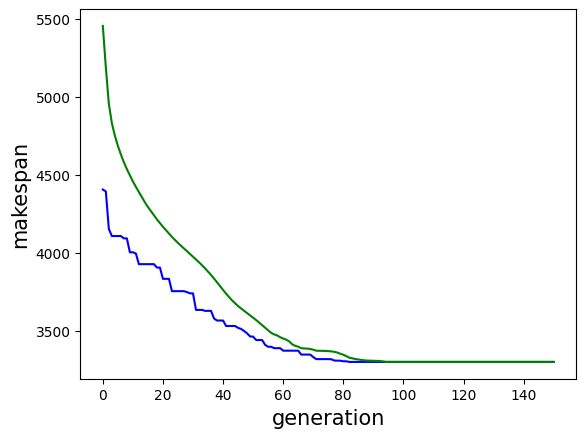

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([i for i in range(len(best_outputs))],[-i for i in best_outputs],'b')
plt.plot([i for i in range(len(mean_outputs))],[-i for i in mean_outputs],'g')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)
plt.show()

結果討論：本project只有探討DMU01與DMU44但我們還有做過DMU06與DMU46，不過效果很差，所以沒有在project中呈現，但我不想讓結果浪費，所在這邊特別呈現。

| **題目** | **size** | **UB** | **OR\-Tools\(做2min\)** | **GA\(做？min\)** | **GA與UB比較** |
|--------|----------|--------|------------------------|-----------------|-------------|
| DMU01  | 20\*15   | 2563   | 2587                   | 3173\(65min\)   | \+610       |
| DMU06  | 20\*20   | 3244   | 3346                   | 4155\(120min\)  | \+991       |
| DMU44  | 20\*15   | 3488   | 3646                   | 4503\(450min\)  | \+1055      |
| DMU46  | 20\*20   | 4035   | 4230                   | 5648\(120min\)  | \+1613      |     

可以發現同參數，size越大，效果會變越差。

6. 將結果轉成FlexSim需要的格式

In [50]:
def Func_order(x):               
    opJob = np.zeros(NUM_JOB, dtype=int)    # opJob[i] = current operation ID of job i
    opMS = np.zeros(NUM_MACHINE, dtype=int)
    answer_order = np.zeros((NUM_MACHINE, NUM_JOB))
    
    for i in range(NUM_BIT):
        m = mOrder[x[i]][opJob[x[i]]]
        answer_order[m][opMS[m]] = x[i]
        opJob[x[i]] += 1
        opMS[m] +=1
               
    return answer_order   

answer = Func_order(pop[0])
for i in range(NUM_MACHINE):
    for j in range(NUM_JOB):
        print(int(answer[i][j] + 1),end=', ')
    print('\n')

1, 18, 8, 6, 19, 4, 14, 20, 2, 5, 16, 11, 12, 15, 3, 7, 9, 10, 13, 17, 

20, 17, 7, 10, 4, 11, 5, 2, 19, 18, 1, 16, 12, 13, 6, 9, 15, 14, 8, 3, 

11, 20, 2, 6, 13, 1, 7, 4, 5, 15, 12, 10, 3, 18, 17, 16, 8, 14, 19, 9, 

14, 12, 19, 16, 2, 17, 7, 10, 5, 4, 13, 1, 18, 8, 6, 11, 20, 9, 3, 15, 

12, 20, 4, 9, 19, 16, 3, 2, 13, 5, 7, 17, 18, 14, 6, 10, 1, 11, 8, 15, 

14, 5, 3, 6, 10, 13, 20, 19, 12, 4, 1, 11, 9, 15, 8, 18, 16, 7, 17, 2, 

7, 12, 1, 9, 15, 11, 3, 19, 10, 13, 16, 4, 6, 17, 18, 5, 20, 8, 14, 2, 

2, 16, 8, 11, 17, 20, 10, 3, 15, 18, 6, 19, 7, 12, 1, 14, 13, 4, 9, 5, 

18, 9, 14, 13, 15, 10, 4, 8, 20, 7, 11, 12, 6, 3, 17, 2, 5, 1, 16, 19, 

13, 16, 5, 10, 3, 17, 8, 20, 19, 18, 12, 7, 14, 2, 15, 11, 4, 6, 9, 1, 

15, 20, 5, 16, 13, 7, 19, 17, 9, 3, 10, 1, 12, 2, 18, 6, 8, 14, 11, 4, 

19, 16, 3, 15, 14, 17, 18, 20, 5, 2, 1, 8, 10, 7, 6, 12, 4, 11, 9, 13, 

13, 5, 14, 19, 17, 10, 1, 7, 2, 3, 6, 18, 15, 9, 11, 12, 8, 4, 20, 16, 

9, 8, 4, 1, 12, 11, 19, 3, 6, 15, 20, 7, 18, 16, 14

#**問題與討論**

- 時間問題：我發現我自己花太多時間在理解code，以及架構還有如何去運行上，而在手動試參數的過程沒有完整記錄數據，導致重複試一樣的參數很多次，但設定超參數跑回圈的話會需要超多時間，可能一兩天以上，我覺得這部分要再精進不過時間有限，應該要去學習如何調參而避免手動調參。

- 架構流程問題：我一直在嘗試與參考資料不一樣的解法或流程，想尊重教授以及網路上創作者的原創性，但耗費了巨量時間，還導致有生成了大量細節差異的版本，也沒有完成好演算法(我認為還有錯誤)，目前算是東拼西湊的結果，我希望我能在這方面在加強與改進，會再將這套code更加完整化。

by 蘇慬